In [36]:
words = open('names.txt').read().splitlines()

In [37]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [38]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [65]:

block_size = 3

In [39]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size

        for c in w + '.':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)

            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X, Y = build_dataset(words)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev= build_dataset(words[n1:n2])
Xtr, Ytr = build_dataset(words[n2:])

In [40]:
n1

25626

In [41]:
C = torch.randn((27, 2))

In [42]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [43]:
W1 = torch.randn((6, 100))
B1 = torch.randn(100)

In [44]:
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + B1)

In [45]:
W2 = torch.randn((100, 27))
B2 = torch.randn(27)


In [46]:
logits = h @ W2 + B2
logits

tensor([[  1.4451,  16.4496,   0.1853,  ...,  -2.0496,   8.7358,   3.1166],
        [ -6.0178,  17.3655,  13.6722,  ...,  10.1021,   1.6210,   2.7369],
        [  0.7595,  -2.8308,   3.5268,  ...,   4.5772,   3.1402,   0.7761],
        ...,
        [  8.0877,  19.5747, -16.3064,  ...,  -0.4378,  -1.7650,  -4.3762],
        [-14.2036, -12.5258,  10.5978,  ...,   3.7139,   6.4571,  14.3390],
        [  0.6840,  -4.9767,   3.9512,  ...,   7.8771,  -6.8253,   0.4349]])

In [47]:
counts = logits.exp()

In [48]:
prob = counts / counts.sum(1, keepdim=True)
prob.shape

torch.Size([228146, 27])

In [49]:
# loss = -prob[torch.arange(32), Y].log().mean()
# loss

In [50]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters: p.requires_grad = True

In [51]:
sum(p.nelement() for p in parameters)

11897

In [52]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [53]:
torch.device("cuda")

device(type='cuda')

In [54]:
torch.device('cpu')

device(type='cpu')

In [55]:
lri = []
lossi = []
stepi = []

In [56]:
# forward pass
for i in range(200000):
    # minibatch 
    ix = torch.randint(0, Xtr.shape[0], (32,))

    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    for p in parameters:
        p.grad = None

    loss.backward()

    # lr = lrs[i]
    lr = 0.1 if i <= 100000 else 0.01
    # lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    stepi.append(i)
    lossi.append(loss.log10().item())

loss.item()

1.642215371131897

In [63]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss.item()

1.8047982454299927

In [75]:
emb = C[Xdev]
print(emb.view(-1, 30).shape)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

torch.Size([22655, 30])


2.512981414794922

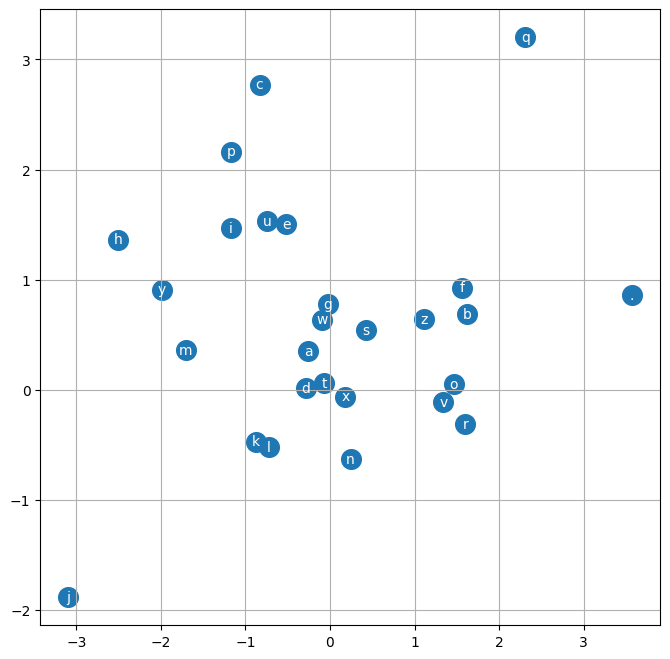

In [59]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('white')

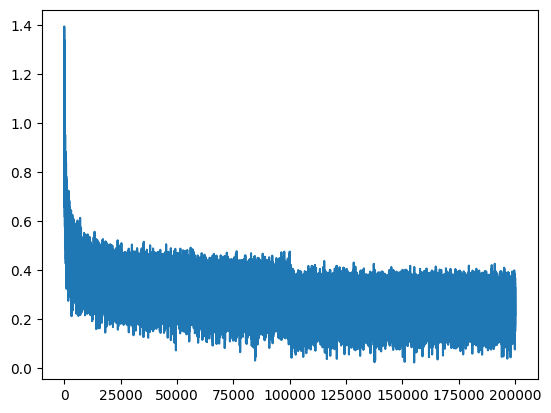

In [60]:
plt.plot(stepi, lossi)

In [61]:
loss.item()

2.512981414794922

In [79]:
for _ in range(20):
    out = []
    context = [0] * block_size

    while True:
        emb = C[torch.tensor([context])]
        # print(emb.view(-1, 30))
        # print(W1.shape)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1);
        ix = torch.multinomial(probs, num_samples=1).item()
        
        if ix == 0:
            break

        context = context[1:] + [ix]
        out.append(ix)

    print(''.join(itos[i] for i in out))

aryn
seban
nwyelamianna
zoaci
deanne
eriah
yael
ishte
osheea
malayne
janme
cesianah
lakheraya
nemila
andanah
jesusd
kenzis
lin
kun
lextolfo
